The purpose of this file is to compute baseline metrics, that is the performance if you use the `average fingerprint` as input (08/30/22)

In [1]:
import os
from matplotlib import pyplot as plt
%matplotlib inline 
os.chdir("../..")

In [2]:
from datasets.hsqc_folder_dataset import FolderDataset
from utils.ranker import RankingSet
from models.compute_metrics import cm

In [6]:
path = "/workspace/Spectre/tempdata/hyun_fp_data/hsqc_ms_pairs"
train = FolderDataset(dir = path, split="train", input_src=["HSQC"])
val = FolderDataset(dir = path, split="val", input_src=["HSQC"])
ranker = RankingSet(file_path = "/workspace/Spectre/tempdata/hyun_pair_ranking_set_07_22/val_pair.pt", device="cuda")

In [4]:
import torch
from tqdm import tqdm
def accumulate_fp(store,ds):
    ds_len = len(ds)
    for i in tqdm(range(ds_len)):
        hsqc, fp = ds[i]
        store[:] += fp
base = torch.zeros(6144)
accumulate_fp(base, train)

100%|██████████| 9794/9794 [00:26<00:00, 366.42it/s]


num_train: 9794, num_nonzero: 3790, max_avg_fp_val: 1.0


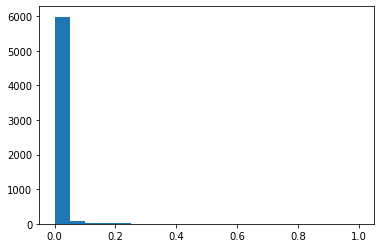

In [5]:
from matplotlib import pyplot as plt

# Some metrics
num_train = len(train)
num_nonzero = len(torch.nonzero(base))
avg_fp = base / num_train
max_avg_fp_val = max(avg_fp)

print(f"num_train: {num_train}, num_nonzero: {num_nonzero}, max_avg_fp_val: {max_avg_fp_val}")

plt.hist(avg_fp.numpy(), bins=20)
plt.show()

In [15]:
import numpy as np
loss_fn = torch.nn.BCELoss()
def accumulate_metrics(avg, ds, ranker):
    avg = avg.cuda()
    unsqueeze_avg = avg.unsqueeze(0)
    metrics = []
    ds_len = len(ds)
    for i in tqdm(range(ds_len)):
        hsqc, fp = ds[i]
        fp = fp.cuda()
        unsqueeze_fp = fp.unsqueeze(0)
        loss = loss_fn(unsqueeze_avg, unsqueeze_fp)
        metrics.append(cm(unsqueeze_avg, unsqueeze_fp, ranker, loss))
    keys = metrics[0].keys()
    accumulate = {k:np.mean([m[k] for m in metrics])for k in keys}
    return accumulate
metrics = accumulate_metrics(avg_fp, val, ranker)

100%|██████████| 1224/1224 [00:31<00:00, 38.32it/s]


In [16]:
print(metrics)

{'ce_loss': 0.03362490999317588, 'cos': 0.40042275044263576, 'active_bits': 18.0, 'f1': 0.34398664093696446, 'precision': 0.7023874364560638, 'recall': 0.2368999650199502, 'accuracy': 0.9919200888905911, 'rank_1': 0.0008169934640522876, 'rank_5': 0.004084967320261438, 'rank_10': 0.008986928104575163}
